In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys, string, re, itertools, random 

#more_itertools, random
#from more_itertools import take

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src import visualizations as vz
from src import functions as fn                                   

# # updates for nltk helper packages if needed
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
                                     
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Project Goals & Overview:
Develop and train a natural language processing model to classify the sentiment of tweets.

## Business Understanding:
Companies can benefit from understanding how consumers perceive and feel about their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner.

## Data Understanding:
The data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions). 

## Data Preparation I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = os.path.join(gparent, 'data/raw',\
                           'judge-1377884607_tweet_product_company.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<font size="4">We are going to look at the single missing tweet right now and save the nulls in the second column for later.</font>

## Checking the Null Tweet:
We have one null value in the `tweet` column we need to deal with.

In [6]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


## Dropping the Null Tweet

In [7]:
df.drop(6, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Renaming Columns:
The original names are a bit unwieldy.

In [9]:
rename_dict = {'tweet_text': 'tweet', 
               'emotion_in_tweet_is_directed_at': 'brand_product', 
               'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion' }
df.rename(columns=rename_dict, inplace=True)
df.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking for Duplicated Tweets:
If there are duplicated tweets, they probably won't add usefull information and most likely will be dropped.

In [10]:
# checking the shape baseline shape and saving it to a variable
original_shape = df.shape
original_shape

(9092, 3)

In [11]:
# filtering for dupes
dupes = df[df['tweet'].duplicated()]

In [12]:
# checking the number of dupes
len(dupes)

27

## Examining the Dupes:
Since there are only 27 dupes, we'll just examine all of them.

In [13]:
dupes

,tweet,brand_product,emotion
467,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
775,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
2231,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product
2558,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3812,Win free ipad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3813,Win free iPad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3949,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3961,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4896,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5337,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,No emotion toward brand or product


<font size="4">Other than the fact that there are a lot of retweets in the dupes, nothing else really stands out. Since we are losing only 27 rows of data, dropping seems like a safe decision.</font>

## Dropping Dupes

In [14]:
df.drop_duplicates(subset='tweet',inplace=True)
df.reset_index(drop=True, inplace=True)

In [15]:
# comparing shapes
print(f'original shape: {original_shape}')
print(f'new shape: {df.shape}')

original shape: (9092, 3)
new shape: (9065, 3)


## Checking for Links:
Checking for url and {link} strings and getting a link count.

In [16]:
# checking for links
tweets = df['tweet']
links = fn.find_strings(tweets, r'(https*\S+)|(\{link\})')
print(links[:25])
len(links)

[[('http://ht.ly/49n4M', '')], [('http://bit.ly/ieaVOB', '')], [('http://bit.ly/gVLrIn', '')], [('http://j.mp/grN7pK)', '')], [('http://bit.ly/aXZwxB', '')], [('http://tinyurl.com/4nqv92l', '')], [('http://bit.ly/hTdFim', '')], [('http://t.co/kfN3f5Q', '')], [('http://t.co/g4GZypV', '')], [('http://tumblr.com/x6t1pi6av7', '')], [('http://bit.ly/hTdFim', '')], [('http://bit.ly/etsbZk', '')], [('http://t.co/A3xvWc6', '')], [('http://itunes.apple.com/us/app/holler-gram/id420666439?mt=8', '')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')]]


4175

<font size="4">Since these strings don't add sentiment information, we'll strip them out during the cleaning process.</font>

## Adding a Hashtag Column:
Hashtags have the potential to contain value information, so we'll create a new column to help explore them.

In [17]:
# copying hashtags to a new column and setting any empty lists to NaNs
df['hashtags'] = df['tweet'].apply(lambda x: 
                                   re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

In [18]:
# checking info & first 5 rows
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          9065 non-null   object
 1   brand_product  3280 non-null   object
 2   emotion        9065 non-null   object
 3   hashtags       9065 non-null   object
dtypes: object(4)
memory usage: 283.4+ KB
None


,tweet,brand_product,emotion,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[#SXSW]


## Exploring the Hashtags
Creating a list and checking the length.

In [19]:
# creating a hashtag list
hashlists = df['hashtags'].tolist()

In [20]:
print(f'hashlists length: {len(hashlists)}')

hashlists length: 9065


In [21]:
hashlists[:5]

[['#RISE_Austin', '#SXSW'],
 ['#SXSW'],
 ['#iPad', '#SXSW'],
 ['#sxsw'],
 ['#SXSW']]

In [22]:
hash_counts = []
for listy in hashlists:
    hash_counts.append(len(listy))
print(f'total tags: {np.sum(hash_counts)}')
print(f'ave tags: {np.sum(hash_counts)/len(hash_counts)}')
print(f'max tags: {max(hash_counts)}')

total tags: 15779
ave tags: 1.7406508549365691
max tags: 12


<font size="5"> There are 15,779 hashtags.</font>

<font size="5"> The average number of hashtags per tweet is 1.74.</font>

<font size="5"> The maximum number of hashtags in a single tweet is 12.</font>

<font size ="5"> Below is the tweet with the max number of hashtags and a list of the hashtags.</font>

In [23]:
print(df.iloc[np.argmax(hash_counts)][0])

print(hashlists[np.argmax(hash_counts)])

iPad 2 and Its Rivals: How They Stack Up {link} #bnet #biz #ipad2 #apple #sxsw #ipad #tablet #xoom #tech #laptop #pics #sale
['#bnet', '#biz', '#ipad2', '#apple', '#sxsw', '#ipad', '#tablet', '#xoom', '#tech', '#laptop', '#pics', '#sale']


## Checking for Empty Lists & Converting to NaNs
Converting and checking length.

In [24]:
df['hashtags'] = df['hashtags'].apply(lambda x: np.nan if len(x) == 0 else x)

In [25]:
df['hashtags'].isna().sum()

10

## Checking Tweets with no Hashtags
There are 10 tweets that don't have a hashtag that we'll examine.

In [26]:
df[df['hashtags'].isna()]

,tweet,brand_product,emotion,hashtags
307,And a few are Android too RT @mention 10 New M...,Android App,Positive emotion,NaN
471,"Before It Even Begins, Apple WinsåÊ#SxSW, {lin...",Apple,Positive emotion,NaN
768,Google to Launch Major New Social Network Call...,Google,Positive emotion,NaN
791,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product,NaN
930,To buy or not to buy RT @mention Before It Eve...,Apple,Positive emotion,NaN
1139,ÛÏ@mention The 10 most dangerous IPhone apps....,NaN,No emotion toward brand or product,NaN
2427,Extra iPad 2 for sale in Austin convention cen...,NaN,No emotion toward brand or product,NaN
3477,GENIUS behind Google Circles.\n¡á¾_Î¾Ð¡____...,Other Google product or service,Positive emotion,NaN
5015,RT @mention,NaN,No emotion toward brand or product,NaN
5538,"RT @mention Before It Even Begins, Apple Winså...",Apple,Positive emotion,NaN


<font size="4">It doesn't appear that there is any pattern to the tweets with no hashtags.</font>

## Checking the Hashtag Set
Removing NaNs, making a list, converting to lowercase and forming a set.

In [27]:
# removing Nans
hashlists = df.hashtags.tolist()
hashlists = [h_list for h_list in hashlists if str(h_list) != 'nan']

In [28]:
# checking length
len(hashlists)

9055

In [29]:
# unpacking hashtags & lowercasing
hashtags = [hashtag.lower() for h_list in hashlists for hashtag in h_list]

In [30]:
# checking work
hashtags[:5]

['#rise_austin', '#sxsw', '#sxsw', '#ipad', '#sxsw']

In [31]:
# making a set and checking length
len(set(hashtags))

1460

<font size="4">There are 1,460 unique hashtags.</font>

## Visualizing the Top 20 Hashtags
Graphing the counts and frequencies of the top 20 hashtags.

In [32]:
# creating a dataframe for the plots
hts = pd.DataFrame(hashtags, columns=['hashtags'])

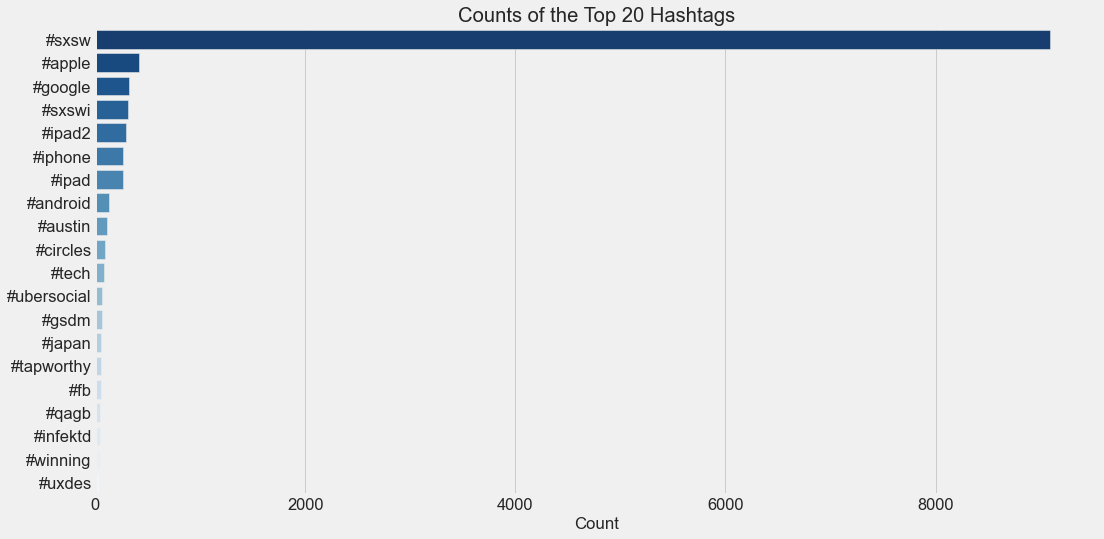

In [33]:
vz.hashtag_c(hts)

In [34]:
hts['hashtags'].value_counts()[:20]

#sxsw          9087
#apple          416
#google         321
#sxswi          316
#ipad2          296
#iphone         265
#ipad           264
#android        131
#austin         112
#circles         98
#tech            87
#ubersocial      68
#gsdm            64
#japan           58
#tapworthy       54
#fb              52
#qagb            50
#infektd         48
#winning         44
#uxdes           40
Name: hashtags, dtype: int64

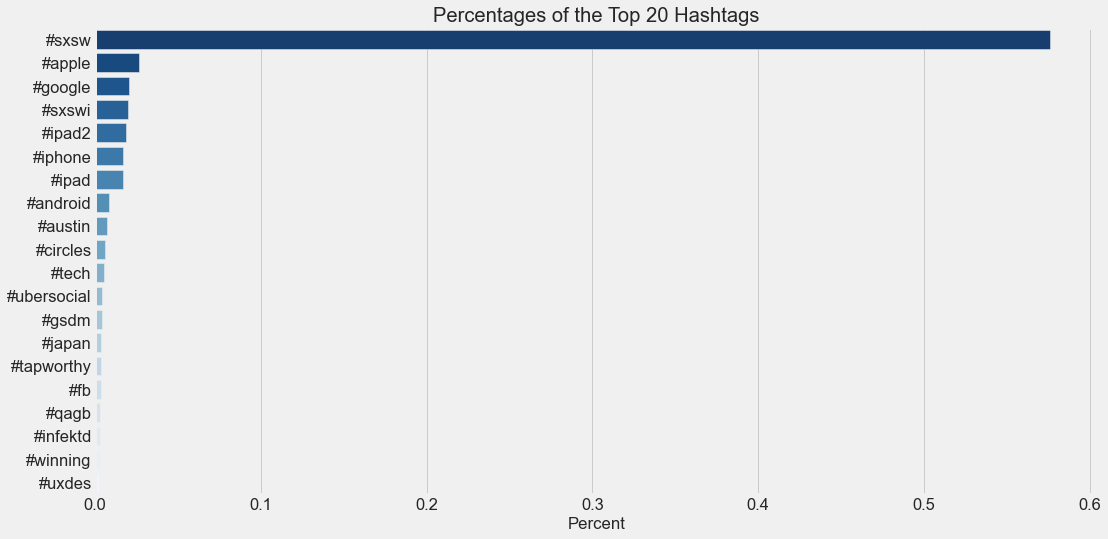

In [35]:
vz.hashtag_p(hts)

In [36]:
hts['hashtags'].value_counts(normalize=True)[:20]

#sxsw          0.575892
#apple         0.026364
#google        0.020343
#sxswi         0.020027
#ipad2         0.018759
#iphone        0.016794
#ipad          0.016731
#android       0.008302
#austin        0.007098
#circles       0.006211
#tech          0.005514
#ubersocial    0.004310
#gsdm          0.004056
#japan         0.003676
#tapworthy     0.003422
#fb            0.003296
#qagb          0.003169
#infektd       0.003042
#winning       0.002789
#uxdes         0.002535
Name: hashtags, dtype: float64

<font size="4">We can see from the graphs above that the vast majority (58%) of the hashtags are `#sxsw`. Every other hashtag is less than 2.7% of the total number of hashtags.</font>

## Checking for RTs
Collecting the retweets checking the count. 

In [37]:
RTs = fn.find_strings(df['tweet'], '(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)')

In [38]:
RTs[:5]

[['RT @madebymany'],
 ['RT @hamsandwich'],
 ['RT @malbonster'],
 ['RT @LaurieShook'],
 ['RT @mention']]

In [39]:
len(RTs)

2551

<font size="4"> There are 2551 retweets. </font>

## Checking for Mentions
Collecting the mentions checking the count

In [40]:
ats = fn.find_strings(df['tweet'], '@[A-Za-z]+[A-Za-z0-9-_]+')
ats[:5]

[['@wesley83'],
 ['@jessedee', '@fludapp'],
 ['@swonderlin'],
 ['@sxsw'],
 ['@sxtxstate']]

In [41]:
len(ats)

4903

<font size="4"> There are 4903 mentions. </font>

## Checking Brand/Product Counts and Frequencies

In [42]:
len(df.brand_product.unique())

10

<font size="4">The are 10 unique values in the `Brand/Product` column including `NaN`.</font>

In [43]:
df.brand_product.isna().sum()/df.shape[0]

0.6381687810259239

<font size="4">63% of the rows have null values in the `Brand/Product` column.</font>

In [44]:
df.brand_product.value_counts().sum()/df.shape[0]

0.3618312189740761

<font size="4">36% of rows have non-null brand data.</font >

In [45]:
df.brand_product.value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: brand_product, dtype: float64

In [46]:
idx = [0, 1, 2, 4, 8]
sum = 0
for i in idx:
    sum += df.brand_product.value_counts(normalize=True)[i]
sum

0.7323170731707316

<font size="4">The Apple brand and Apple products account for 73% of the brand data.</font>

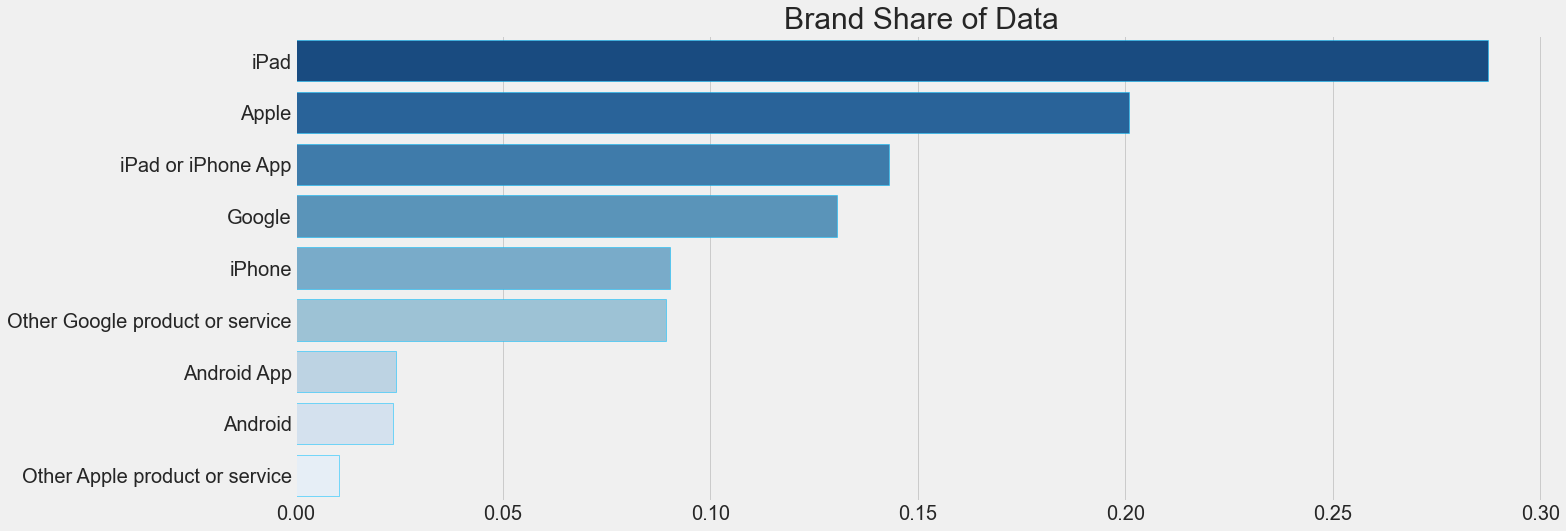

In [47]:
vz.brand_freqs(df)

<font size="4"> The graph above confirm Apple's predominance in the `Brand/Product` column. </font>

## Checking Emotion Unique Values

In [48]:
len(df.emotion.unique())

4

<font size="4">There are 4 unique values in the emotion category.</font>

In [49]:
df.emotion.value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

In [50]:
df.emotion.value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327413
Negative emotion                      0.062769
I can't tell                          0.017209
Name: emotion, dtype: float64

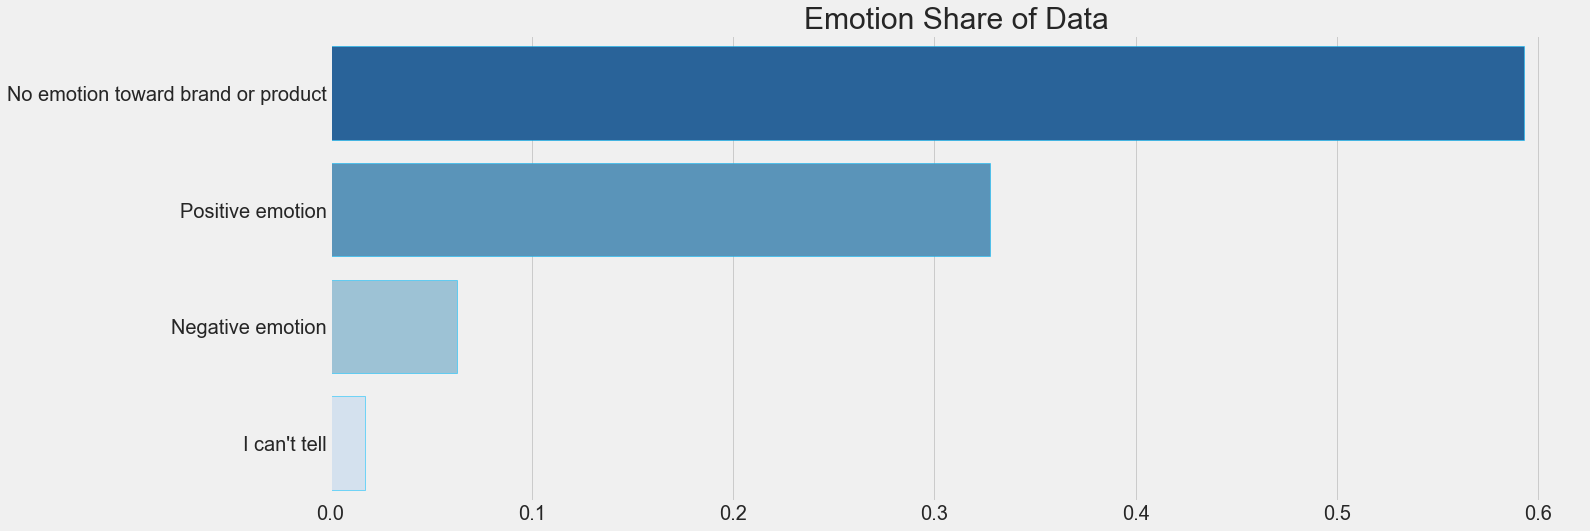

In [51]:
vz.emotion_freqs(df)

<font size="4">`No emotion toward brand or product` accounts for 59% of the data.</font>

<font size="4">`Positive emotion`                   accounts for 33% of the data.</font>

<font size="4">`Negative emotion`                   accounts for 6% of the data.</font>

<font size="4">`I can't tell`                       accounts for 2% of the data.</font>

<font size="4">We want to be able to detect the emotional sentiment of the tweets so we'll drop the `I can't tell` labels.</font>

In [52]:
# getting the original number of rows
before = df.shape[0]

# saving number of 'can't tell' rows
num_cant_tell =df.emotion.value_counts()[3]

# dropping the 'can't tell' rows
df = df[~(df['emotion']=='I can\'t tell')]

# resetting index
df.reset_index(drop=True, inplace=True)

# checking that the number of rows dropped match the number of 'can't tell' rows
before - df.shape[0] == num_cant_tell

True

## Emotions by Brand

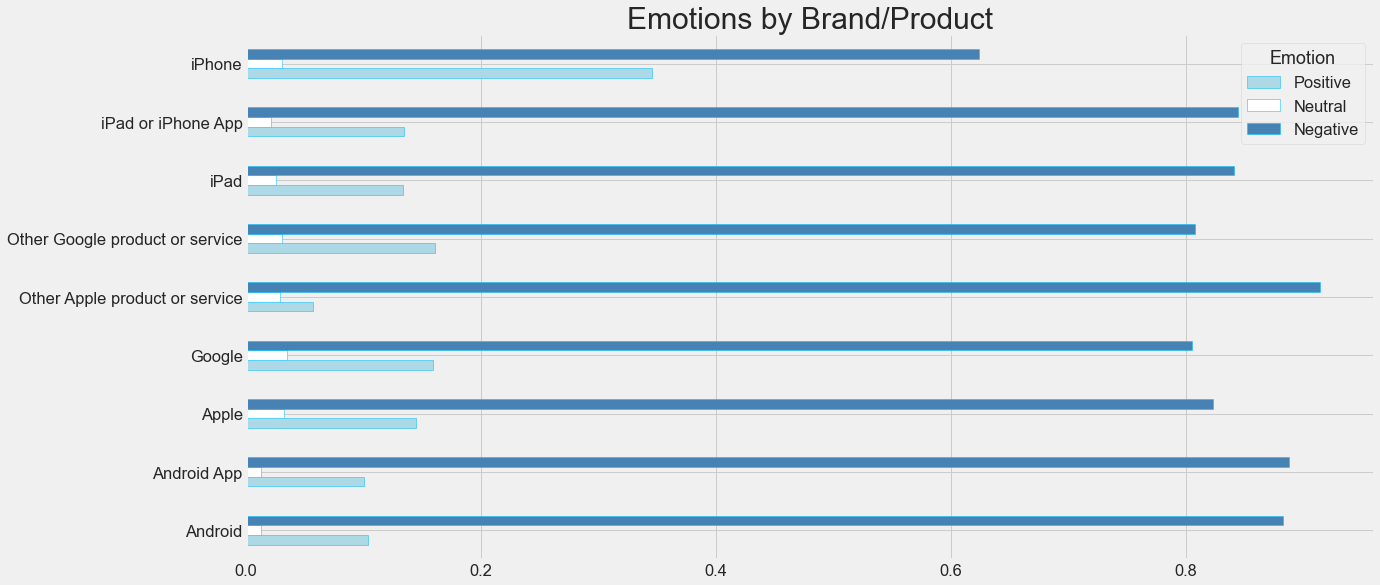

In [53]:
vz.brand_emotions(df)

## Checking Nulls in Product Column

In [54]:
product_nulls = df[df['brand_product'].isnull()]

In [55]:
product_nulls.head()

,tweet,brand_product,emotion,hashtags
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,"[#SpeechTherapy, #SXSW, #iear, #edchat, #asd]"
15,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,[#sxsw]
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,"[#SXSW, #GDGTLive]"
32,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,[#sxsw]
33,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product,[#SXSW]


In [56]:
product_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5638 entries, 5 to 8908
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          5638 non-null   object
 1   brand_product  0 non-null      object
 2   emotion        5638 non-null   object
 3   hashtags       5634 non-null   object
dtypes: object(4)
memory usage: 220.2+ KB


In [57]:
product_nulls['emotion'].value_counts()

No emotion toward brand or product    5281
Positive emotion                       306
Negative emotion                        51
Name: emotion, dtype: int64

## Checking Null Brands Emotion Data

In [58]:
null_brand_emotions = df[(df['brand_product'].isna()) &\
                        (df['emotion'] != 'No emotion toward brand or product')]

In [59]:
null_brand_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 45 to 8872
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          357 non-null    object
 1   brand_product  0 non-null      object
 2   emotion        357 non-null    object
 3   hashtags       357 non-null    object
dtypes: object(4)
memory usage: 13.9+ KB


In [60]:
null_brand_emotions.head()

,tweet,brand_product,emotion,hashtags
45,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion,[#SXSW]
63,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion,[#sxsw]
67,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative emotion,[#sxsw]
100,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative emotion,[#sxsw]
109,Spark for #android is up for a #teamandroid aw...,NaN,Positive emotion,"[#android, #teamandroid, #SXSW]"


## Null Brand Emotion Counts

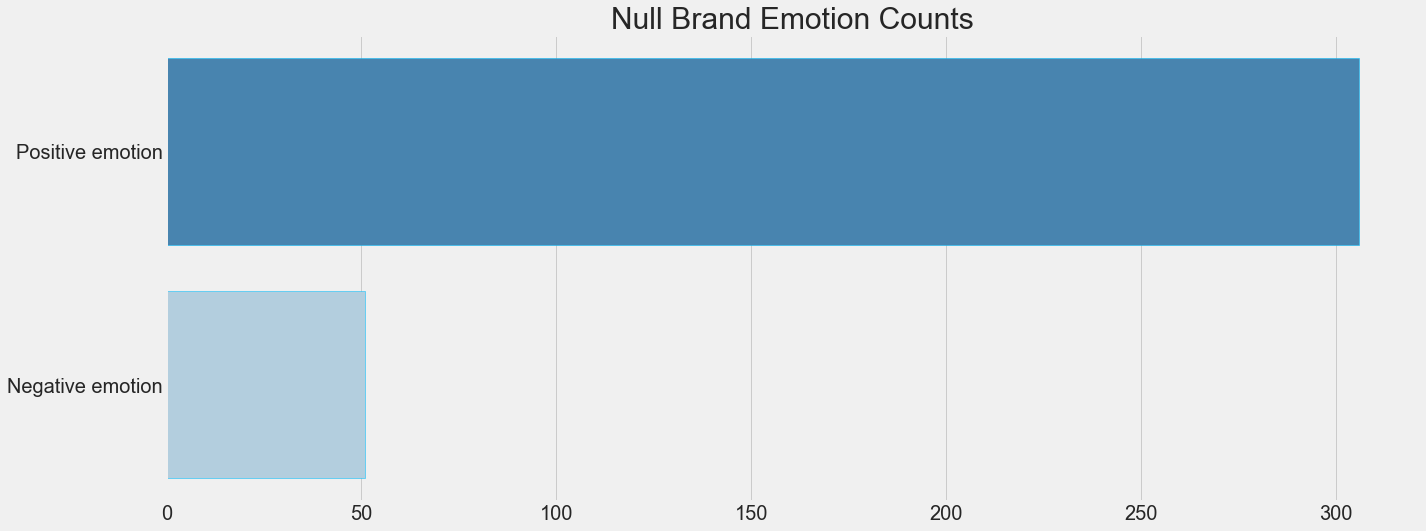

In [61]:
vz.null_brand_emotions(df)

## Examining Some Null Brand Tweets

In [62]:
print(null_brand_emotions.tweet[45])

Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}


In [63]:
print(null_brand_emotions.tweet[63])

Again? RT @mention Line at the Apple store is insane.. #sxsw


In [64]:
print(null_brand_emotions.tweet[67])

Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw


## Exploring Hashtags in the Data

In [65]:
data_hashtags = fn.ht_extract(df.tweet)

In [66]:
data_hashtags[:5]

['#rise_austin', '#sxsw', '#sxsw', '#ipad', '#sxsw']

In [67]:
len(data_hashtags)

15533

In [68]:
len(set(data_hashtags))

1443

In [69]:
data_hts = pd.DataFrame(data_hashtags, columns=['hashtags'])

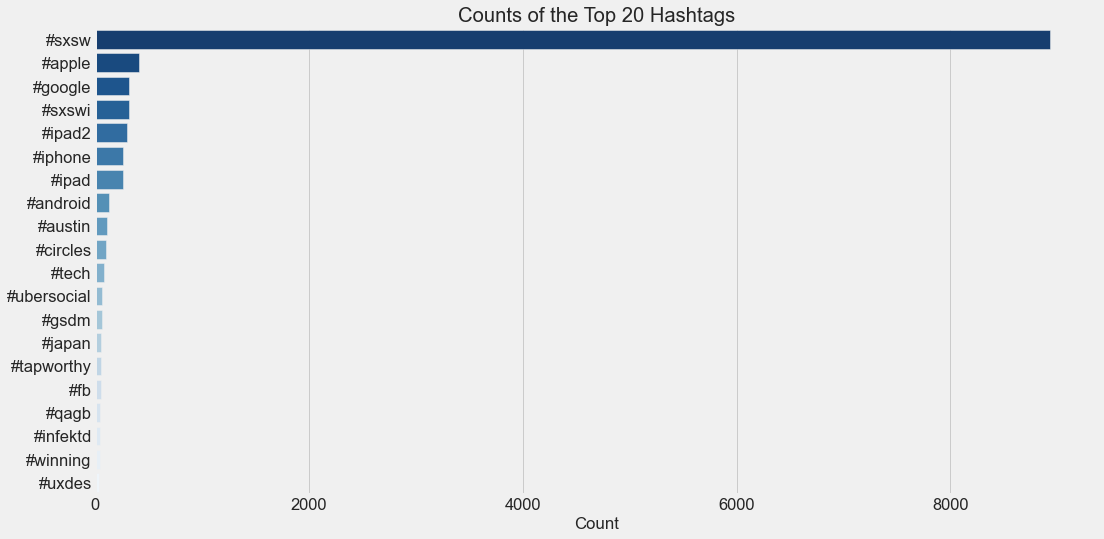

In [70]:
vz.hashtag_c(data_hts)

In [71]:
data_hts.value_counts()[:20]

hashtags   
#sxsw          8930
#apple          413
#google         318
#sxswi          313
#ipad2          294
#iphone         262
#ipad           260
#android        130
#austin         110
#circles         97
#tech            87
#ubersocial      68
#gsdm            63
#japan           56
#tapworthy       53
#fb              52
#qagb            49
#infektd         48
#winning         44
#uxdes           38
dtype: int64

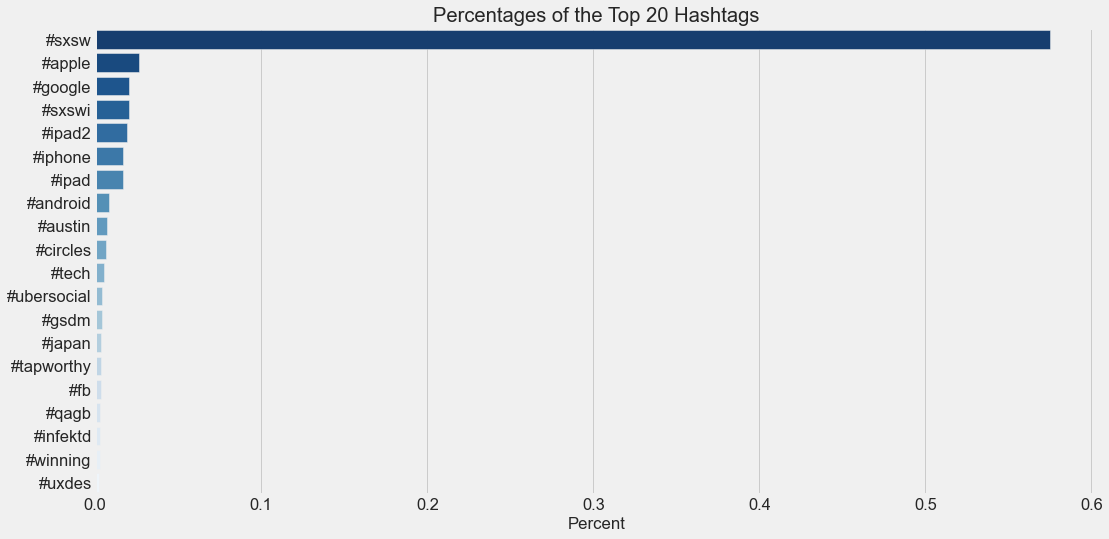

In [72]:
vz.hashtag_p(data_hts)

In [73]:
data_hts.value_counts(normalize=True)[:20]

hashtags   
#sxsw          0.574905
#apple         0.026589
#google        0.020473
#sxswi         0.020151
#ipad2         0.018927
#iphone        0.016867
#ipad          0.016739
#android       0.008369
#austin        0.007082
#circles       0.006245
#tech          0.005601
#ubersocial    0.004378
#gsdm          0.004056
#japan         0.003605
#tapworthy     0.003412
#fb            0.003348
#qagb          0.003155
#infektd       0.003090
#winning       0.002833
#uxdes         0.002446
dtype: float64

## Checking for RTs in the Data

In [74]:
RTs_data = fn.find_strings(df.tweet, '(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)')

In [75]:
RTs_data[:5]

[['RT @madebymany'],
 ['RT @hamsandwich'],
 ['RT @malbonster'],
 ['RT @LaurieShook'],
 ['RT @mention']]

In [76]:
len(RTs_data)

2521

## Checking for @s in the Data

In [77]:
ats_data = fn.find_strings(df.tweet, '@[A-Za-z]+[A-Za-z0-9-_]+')
ats_data[:5]

[['@wesley83'],
 ['@jessedee', '@fludapp'],
 ['@swonderlin'],
 ['@sxsw'],
 ['@sxtxstate']]

In [78]:
len(ats_data)

4834

## Data Preparation II: (Cleaning the Data)
The master cleaning functions remove punctuation, urls, retweets, mentions, other unwanted substrings ('{link}', &amp, &quot, &nbsp, &lt, &gt), lower case all letters, and return a list of clean and regularized (lemmas or stems) tweets.

In [79]:
data_clean_lemmas = fn.clean_corpus_lem(df.tweet)

In [80]:
data_clean_stems = fn.clean_corpus_stem(df.tweet)

## Comparing Raw Tweets to the Cleaned & Regularized Tweets

In [81]:
for i in range(100):
    print(f'original: {df.tweet[i]}\n')
    print(f'lemms: {data_clean_lemmas[i]}')
    print(f'stems: {data_clean_stems[i]}\n')

original: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.

lemms: 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw
stems: 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw

original: @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW

lemms: know awesome ipad iphone app likely appreciate design also giving free t sxsw
stems: know awesom ipad iphon app like appreci design also give free ts sxsw

original: @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.

lemms: wait ipad 2 also sale sxsw
stems: wait ipad 2 also sale sxsw

original: @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw

lemms: hope year festival crashy year iphone app sxsw
stems: hope year festiv crashi year iphon app sxsw

original: @sxtxstate great st

<font size="4">Looks good, so we''ll add the lemmatized and stemmed tweets  to the data frame as columns.</font>

In [82]:
df['lemmas'] = data_clean_lemmas

In [83]:
df['stems'] = data_clean_stems

In [84]:
df.head()

,tweet,brand_product,emotion,hashtags,lemmas,stems
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[#RISE_Austin, #SXSW]",3g iphone 3 hr tweeting rise austin dead need ...,3g iphon 3 hr tweet rise austin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[#SXSW],know awesome ipad iphone app likely appreciate...,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[#iPad, #SXSW]",wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[#sxsw],hope year festival crashy year iphone app sxsw,hope year festiv crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[#SXSW],great stuff fri sxsw marissa mayer google tim ...,great stuff fri sxsw marissa mayer googl tim r...


## Making the `emotion` Target Ternary

In [85]:
df.emotion.value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
Name: emotion, dtype: int64

In [86]:
df['emotion'] = df['emotion'].replace(['Negative emotion',
                                       'Positive emotion',
                                       'No emotion toward brand or product'],
                                       [0, 1, 2])

In [87]:
df['emotion'].value_counts()

2    5372
1    2968
0     569
Name: emotion, dtype: int64

In [88]:
df.head()

,tweet,brand_product,emotion,hashtags,lemmas,stems
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,"[#RISE_Austin, #SXSW]",3g iphone 3 hr tweeting rise austin dead need ...,3g iphon 3 hr tweet rise austin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,[#SXSW],know awesome ipad iphone app likely appreciate...,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,"[#iPad, #SXSW]",wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,[#sxsw],hope year festival crashy year iphone app sxsw,hope year festiv crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,[#SXSW],great stuff fri sxsw marissa mayer google tim ...,great stuff fri sxsw marissa mayer googl tim r...


## Moving the Target and Regularized Columns to the Front of the Data Frame

In [89]:
cols = ['lemmas', 'stems', 'emotion']

for col in cols:
    c = df.pop(col)
    df.insert(0, col, c)
df.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,0,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"[#RISE_Austin, #SXSW]"
1,1,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,[#SXSW]
2,1,wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"[#iPad, #SXSW]"
3,0,hope year festiv crashi year iphon app sxsw,hope year festival crashy year iphone app sxsw,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,[#sxsw]
4,1,great stuff fri sxsw marissa mayer googl tim r...,great stuff fri sxsw marissa mayer google tim ...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,[#SXSW]


## Exporting the Ternary Data for Modeling

In [90]:
# path = os.path.join(gparent, 'data/processed', 'modeling_ternary.csv')
# df.to_csv(path, index=False)

## EDA on Clean, Regularized Data

## Frequency Distributions of Raw vs Cleaned Data

#### Raw Data

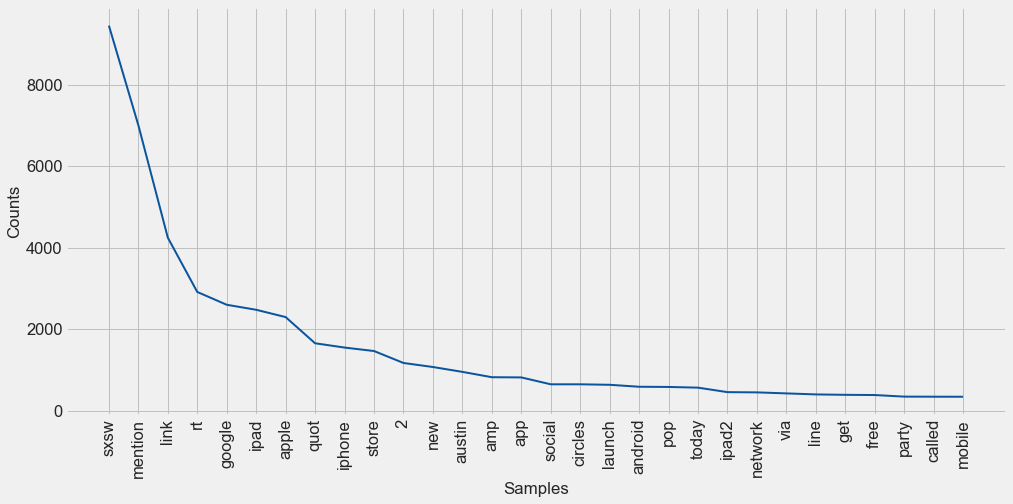

In [91]:
top_raw = top_raw_words = fn.top_word_list(df.tweet, 30, False, True)

<font size="4"> SXSW is by far the most prevalent value, and we can see the 4 out of the top 5 words are unrelated to the relevant brands.</font>

#### Lemmatized Data

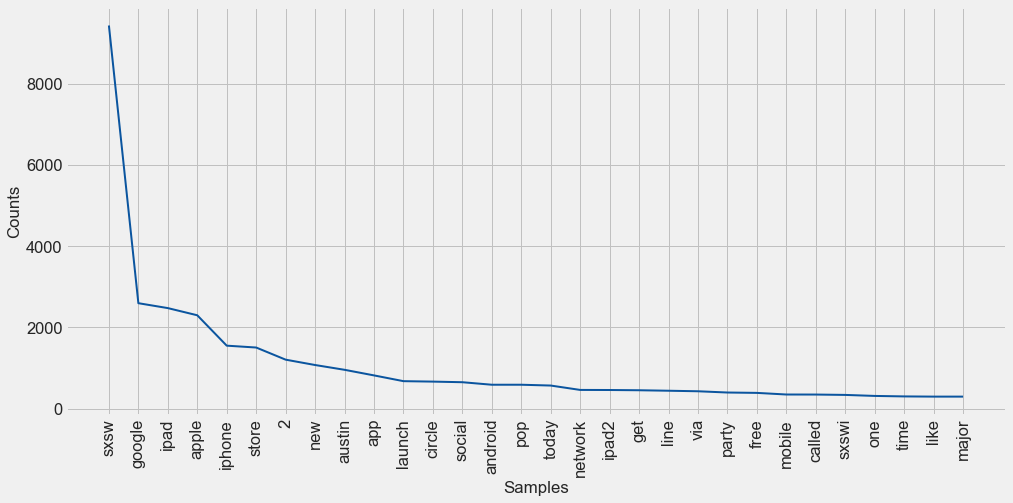

In [92]:
top_lemmas = fn.top_word_list(data_clean_lemmas, 30, False, True)

<font size="4"> SXSW still predominates, but the other 4 in the top 5 are now relevant to the brands.</font>

#### Stemmed Data

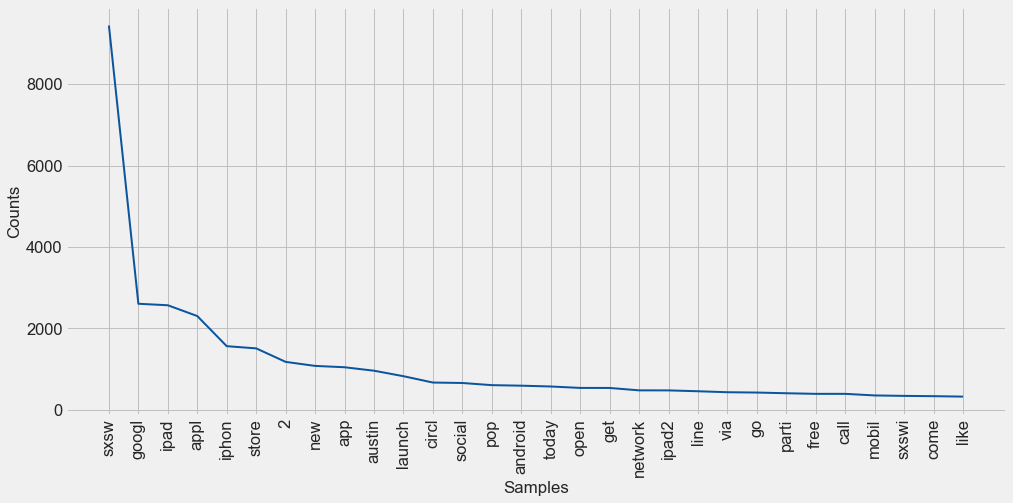

In [93]:
top_stems = fn.top_word_list(data_clean_stems, 30, False, True)

<font size="4"> Again, SXSW dominates, but the rest of the top 4 relate to the relevant brands.</font>

#### Text Comparison

<font size="4">Below is a direct comparison of the top 30 words in each of the 3 groups of tokens.</font> 

In [94]:
print(f'raw tweet: \n {top_raw} \n')
print(f'lemmas: \n {top_lemmas} \n')
print(f'stems: \n{top_stems} \n')

raw tweet: 
 ['sxsw', 'mention', 'link', 'rt', 'google', 'ipad', 'apple', 'quot', 'iphone', 'store', '2', 'new', 'austin', 'amp', 'app', 'social', 'circles', 'launch', 'android', 'pop', 'today', 'ipad2', 'network', 'via', 'line', 'get', 'free', 'party', 'called', 'mobile'] 

lemmas: 
 ['sxsw', 'google', 'ipad', 'apple', 'iphone', 'store', '2', 'new', 'austin', 'app', 'launch', 'circle', 'social', 'android', 'pop', 'today', 'network', 'ipad2', 'get', 'line', 'via', 'party', 'free', 'mobile', 'called', 'sxswi', 'one', 'time', 'like', 'major'] 

stems: 
['sxsw', 'googl', 'ipad', 'appl', 'iphon', 'store', '2', 'new', 'app', 'austin', 'launch', 'circl', 'social', 'pop', 'android', 'today', 'open', 'get', 'network', 'ipad2', 'line', 'via', 'go', 'parti', 'free', 'call', 'mobil', 'sxswi', 'come', 'like'] 



<font size="4"> The lists for all three are pretty similar overall.</font>

## Vocabularies

#### Lemmas Vocabulary

In [95]:
lemma_vocab = fn.vocabulary(data_clean_lemmas)

In [96]:
# checking number of words
len(lemma_vocab)

8636

In [97]:
# first 100 words
for i, val in enumerate(itertools.islice(lemma_vocab, 100)):
    print(val)

jam
seemingly
adele
avoided
bjdproductions
existing
prez
doesnt
equal
frontwoman
drafthouse
h264
brushstroke
alguien
dontbehatin
dont
purchasing
dahl
seen
conv
berklee
positive
gut
bettersearch
bezel
drained
revenge
dope
10am
fellowship
kindda
twilio
thingsthatdontgotogether
become
pavement
behaviour
bus
fight
filtering
wife
bluezoom
spazzmatics
navigating
undoubtedly
instrument
ton
assignment
adfonic
vet
fret
kirkus
whole
jayden
out
blood
ncbshow
go2
fsw
lorry
wtf
mix
japanquake
thinmints
bill
provide
teo
bed
woohoo
cactus
traveling
trek
sustainability
starbucks
feed
effing
hig
bio
androidcrunch
bpm
cm48
pressie
fee
reel
retreat
atari
killing
contactless
unlocking
pecan
banality
iava
inertia
pint
gitchococktailon
choreography
stress
amer
squeeze
blogged
nyt


In [98]:
# random 100 words
for i, val in enumerate(random.sample(lemma_vocab, 100)):
    print(val)

conde
bobby
nest
relies
seesmic
goin
recs
txt
achieve
effect
willinclude
oops
shotgun
diet
writeup
borrow
floating
tg
slew
trashy
hoooooooooooooo
policy
compan
designing
sloanxsw
circle
priest
property
retro
tuesday
geared
msft
boxee
whore
addr
jealous
corralling
brawl
plain
costume
innotribe
flava
gotta
000
geolocation
sneak
get
sxswbarcrawl
edreform
hoy
arctic
hail
skrugsxsw
creo
awesome
capitalism
festivalexplorer
masha
seam
todo
ummmm
cupcake
musicviz
artist
apaan
whether
4g
widely
present
beechwood
facepalmed
invest
sxswparty
print
confess
copy
3pm
attendence
revenue
ranking
sessi
sxsurrogates
critthink
merged
applestore
step
completes
assume
911tweets
recipe
se
couchfan
prepaid
advisory
ceder
smelling
release
thedomain
arduino
knowyouraudience


In [99]:
fn.string_checker(lemma_vocab, 'https')
fn.string_checker(lemma_vocab, 'madebymany')

string is not in data
string is in data


#### Stems Vocabulary

In [100]:
stemma_vocab = fn.vocabulary(data_clean_stems)

In [101]:
# number of words
len(stemma_vocab)

7342

In [102]:
# first 100 words
for i, val in enumerate(itertools.islice(stemma_vocab, 100)):
    print(val)

jam
devop
prez
doesnt
equal
ordin
frontwoman
newmus
h264
notesplu
alguien
dontbehatin
lectur
dont
dahl
seen
conv
daftari
gut
incas
bettersearch
facetim
bezel
honesti
letsdothi
dope
10am
fellowship
kindda
twilio
applic
pavement
behaviour
booz
fight
principl
wife
polici
attende
bluezoom
instrument
ton
tabletwar
agil
importantli
vet
fret
whole
jayden
out
blood
debug
ncbshow
pet
newbi
go2
fsw
wtf
deliber
mix
mophi
suspens
memori
bill
teo
bed
woohoo
demonstr
marketshar
identifi
customiz
trek
feed
hig
bio
androidcrunch
mous
bpm
cm48
poss
fee
reel
retreat
atari
contactless
struggl
sustain
pecan
sleev
iava
tunehopp
inertia
pint
gitchococktailon
regularli
noth
stress
amer
nyt
gah


In [103]:
# random 100 words
for i, val in enumerate(random.sample(stemma_vocab, 100)):
    print(val)

critic
grrrr
iconbuffet
fo
york
nowher
marker
gswsxsw
obsolet
cleveland
thankyoueconomi
brows
marketplac
ecosystem
yea
pressi
brk
muro
todo
practic
cri
summon
donlot
geosoci
impress
occasion
virtualoffic
sxswbusi
clipcon
jose
bob
techgeek
quot
align
world
common
2day
sxswadobemobil
staff
edit
there
iac
csuitecsourc
soundtrckr
term
thoma
stake
novelti
postpc
mktg
on
sf
high
mobile491
button
elitebook
slick
feet
zeldman
sapient
desk
hitlanti
rememb
taunt
techno
sayin
z28
permiss
relat
temptat
eyebal
addit
geekeri
devianta
militari
illeg
iun
evangelist
unexpect
tournament
141st
mater
contrapt
galleri
mart
bloggabl
stori
suppos
bloke
data
fuel
middl
coolest
sake
connect
bubo
add
tummi
distant
evolvingworkplac


In [104]:
fn.string_checker(stemma_vocab, 'https')
fn.string_checker(stemma_vocab, 'madebymany')

string is not in data
string is not in data


## Filtering Down to Binary Target Data
<font size="4"> We want to develop a viable binary classification model first, and then, if time permits, expand it to a ternary model.  Thus, we will filter the data down to rows with positive or negative sentiment.</font>

In [105]:
# filtering
binary_data = df[(df['emotion'] == 0) |\
                 (df['emotion'] == 1)].copy()

In [106]:
# resetting the index
binary_data.reset_index(drop=True, inplace=True)

In [107]:
# checking the first five rows
binary_data.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,0,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"[#RISE_Austin, #SXSW]"
1,1,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,[#SXSW]
2,1,wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"[#iPad, #SXSW]"
3,0,hope year festiv crashi year iphon app sxsw,hope year festival crashy year iphone app sxsw,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,[#sxsw]
4,1,great stuff fri sxsw marissa mayer googl tim r...,great stuff fri sxsw marissa mayer google tim ...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,[#SXSW]


In [108]:
# checking the info
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        3537 non-null   int64 
 1   stems          3537 non-null   object
 2   lemmas         3537 non-null   object
 3   tweet          3537 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3531 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


In [109]:
# checking for nulls
binary_data.isna().sum()

emotion            0
stems              0
lemmas             0
tweet              0
brand_product    357
hashtags           6
dtype: int64

In [110]:
# checking the value counts
binary_data['emotion'].value_counts()

1    2968
0     569
Name: emotion, dtype: int64

## Exporting the Binary Data for Modeling

In [111]:
# path = os.path.join(gparent, 'data/processed', 'modeling_binary.csv')
# binary_data.to_csv(path, index=False)